# Computer Vision Assignment 4


```
Name : SK ABUKHOYER
Roll No : 2021201023
Batch : M.TECH 2nd Year
```



# Header

In [1]:
!pip install PyMaxflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.7/811.7 KB 14.0 MB/s eta 0:00:00


In [10]:
import maxflow
import numpy as np
import re
import sys
import cv2
import matplotlib.pyplot as plt
import math
import os
import time
from matplotlib import cm
import argparse
from google.colab.patches import cv2_imshow
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Disparity maps in stereo images


In [3]:
left_image_path = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-1-disparity-map/scene_L.ppm'
right_image_path = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-1-disparity-map/scene_R.ppm'
ground_truth_disparity = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-1-disparity-map/true_disparity_L.pgm'
input_dir = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data'
output_dir = '/content/drive/MyDrive/Colab Notebooks/CV_A4/results'

In [4]:
left_image = cv2.imread(left_image_path)
right_image = cv2.imread(right_image_path)

cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/CV_A4/results/image_L.png',left_image)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/CV_A4/results/image_R.png',right_image)

gt_disparity = cv2.imread(ground_truth_disparity,-1)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/CV_A4/results/image_ground_truth.png',gt_disparity)

True

In [5]:
print(left_image.shape,right_image.shape,gt_disparity.shape)

(288, 384, 3) (288, 384, 3) (288, 384)


Left image


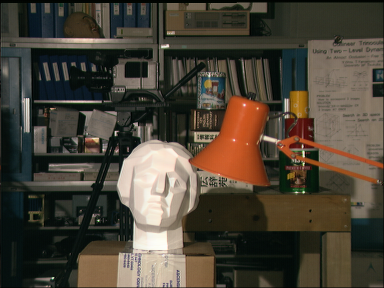

Right image


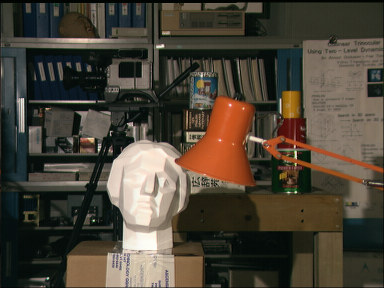

Ground truth disparity image


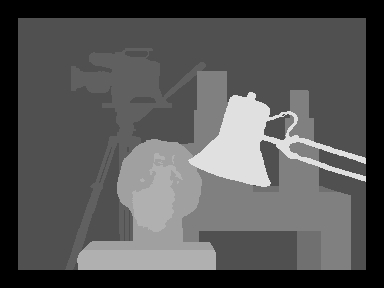

In [6]:
print('Left image')
cv2_imshow(left_image)
print('Right image')
cv2_imshow(right_image)
print('Ground truth disparity image')
cv2_imshow(gt_disparity)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Graph-Cut Implementation

In [7]:
def to_gray(image):
    if len(image.shape) == 2:
        return image.astype(np.float32)
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)

class GraphCutDisparitySolver:
    LABEL_OCCLUDED = 1
    NODE_ALPHA = -1
    NODE_ABSENT = -2
    IS_NODE = lambda x: x >=0

    def __init__(self,image_left,image_right,always_randomize=False,search_depth=30,max_levels=-1,max_iterations=4,occlusion_cost=-1,
                 smoothness_cost_high=-1,smoothness_cost_low=-1,smoothness_threshold=8,):
        # TODO: Validate params
        '''
        
        '''
        self.always_randomize = always_randomize
        self.max_levels = search_depth if max_levels < 0 else max_levels
        self.max_iterations = max_iterations
        self.occlusion_cost = occlusion_cost
        self.smoothness_cost_low = smoothness_cost_low if smoothness_cost_low > 0 else 0.2 * self.occlusion_cost
        self.smoothness_cost_high = smoothness_cost_high if smoothness_cost_high > 0 else 3 * self.smoothness_cost_low
        self.smoothness_threshold = smoothness_threshold

        self.image_left = to_gray(image_left)
        self.image_right = to_gray(image_right)
        self.image_shape = self.image_left.shape
        self.image_size = self.image_left.size
        self.image_indices = np.indices(self.image_shape)
        self.energy = float('inf')

        search_interval = (search_depth // self.max_levels) + bool(search_depth % self.max_levels)
        self.search_levels = -1 * np.arange(0, search_depth + 1, search_interval)[::-1]
        rank = np.empty(len(self.search_levels), dtype=int)
        rank[np.argsort(self.search_levels)] = np.arange(len(self.search_levels))
        self.label_rank = dict(zip(self.search_levels, rank))

        self.build_neighbors()

    def is_in_image(self, x):
        return (0 <= x) & (x < self.image_shape[1])

    def build_neighbors(self):
        indices = np.indices(self.image_shape)

        neighbors_one_p = indices[:, 1:, :].reshape(2, -1)
        neighbors_one_q = neighbors_one_p + [[-1],[0]]
        neighbors_two_p = indices[:, :, :-1].reshape(2, -1)
        neighbors_two_q = neighbors_two_p + [[0],[1]]

        self.neighbors = np.array([
            np.concatenate([neighbors_one_p, neighbors_two_p], axis=1),
            np.concatenate([neighbors_one_q, neighbors_two_q], axis=1),
        ])
        self.neighbors_rolled = list(np.rollaxis(self.neighbors, 1))

        indices_p, indices_q = self.neighbors
        diff_left = self.image_left[list(indices_p)] - self.image_left[list(indices_q)]
        self.is_left_under = np.abs(diff_left) < self.smoothness_threshold

    def solve(self):
        self.labels = np.full(self.image_shape, self.LABEL_OCCLUDED, dtype=np.int)
        label_done = np.zeros(len(self.search_levels), dtype=bool)

        for i in range(self.max_iterations):
            if i == 0 or self.always_randomize:
                label_order = np.random.permutation(self.search_levels)

            for label in label_order:
                # print('iteration', i, 'label', label)
                label_index = self.label_rank[label]
                if label_done[label_index]:
                    continue

                is_expanded = self.expand_label(label)
                if is_expanded:
                    label_done[:] = False
                label_done[label_index] = True

            if label_done.all():
                break

        return -1 * self.labels

    def expand_label(self, label):
        is_expanded = False
        g = maxflow.Graph[int](2*self.image_size, 12*self.image_size)
        # print('Adding data+occlusion terms for', label)
        self.add_data_occlusion_terms(g, label)
        # print('Adding smoothness terms for', label)
        self.add_smoothness_terms(g, label)
        # print('Adding uniqueness terms for', label)
        self.add_uniqueness_terms(g, label)

        energy = g.maxflow() + self.e_data_occlusion
        if energy < self.energy:
            # print('new energy', energy, 'updating labels', label)
            self.update_labels(g, label)
            is_expanded = True
        self.energy = energy
        return is_expanded

    def add_data_occlusion_terms(self, g, label):
        indices_y, indices_x = self.image_indices
        is_label = self.labels == label
        is_occluded = self.labels == self.LABEL_OCCLUDED

        indices_shifted = np.where(is_occluded, indices_x, indices_x + self.labels)
        # assert self.is_in_image(indices_shifted[np.logical_not(is_occluded)]).all()
        ssd_active = np.square(self.image_left - self.image_right[indices_y, indices_shifted]) - self.occlusion_cost
        ssd_active[is_occluded | is_label] = -self.occlusion_cost - 1
        nodes_active = np.zeros(self.image_shape, dtype=np.int)
        nodes_active[is_occluded] = self.NODE_ABSENT
        nodes_active[is_label] = self.NODE_ALPHA
        is_node_active = np.logical_not(is_label | is_occluded)
        e_data_occlusion = ssd_active[is_label].sum()

        is_occluded = np.logical_not(self.is_in_image(indices_x + label))
        indices_shifted = np.where(is_occluded, indices_x, indices_x + label)
        ssd_label = np.square(self.image_left - self.image_right[indices_y, indices_shifted]) - self.occlusion_cost
        ssd_label[is_occluded | is_label] = -self.occlusion_cost - 1
        nodes_label = np.zeros(self.image_shape, dtype=np.int)
        nodes_label[is_occluded] = self.NODE_ABSENT
        nodes_label[is_label] = self.NODE_ALPHA
        is_node_label = np.logical_not(is_label | is_occluded)

        num_nodes = is_node_label.sum() + is_node_active.sum()
        node_ids = g.add_nodes(num_nodes)
        node_index = 0
        for row, col in np.ndindex(self.image_shape):
            if is_node_active[row, col]:
                node_id = node_ids[node_index]
                nodes_active[row, col] = node_id
                node_index += 1
                cost_active = ssd_active[row, col]
                # assert cost_active >= -self.occlusion_cost
                g.add_tedge(node_id, 0, cost_active)

            if is_node_label[row, col]:
                node_id = node_ids[node_index]
                nodes_label[row, col] = node_id
                node_index += 1
                cost_label = ssd_label[row, col]
                # assert cost_label >= -self.occlusion_cost
                g.add_tedge(node_id, cost_label, 0)

        # assert node_index == num_nodes

        self.is_node_active = is_node_active
        self.is_node_label = is_node_label
        self.nodes_active = nodes_active
        self.nodes_label = nodes_label
        self.e_data_occlusion = e_data_occlusion

    def add_smoothness_terms(self, g, label):
        labels_p, labels_q = self.labels[self.neighbors_rolled]

        penalty_label = self.get_smoothness_penalty(label)
        penalty_active_p = self.get_smoothness_penalty(labels_p)
        penalty_active_q = self.get_smoothness_penalty(labels_q)

        indices_p, indices_q = self.neighbors
        is_p_in_range = self.is_in_image(indices_p[1, :] + labels_q)
        is_q_in_range = self.is_in_image(indices_q[1, :] + labels_p)

        for neighbor_index in range(self.neighbors.shape[2]):
            indices_y, indices_x = self.neighbors.T[neighbor_index]
            label_p, label_q = self.labels[indices_y, indices_x]
            node_l_p, node_l_q = self.nodes_label[indices_y, indices_x]
            node_a_p, node_a_q = self.nodes_active[indices_y, indices_x]
            is_p_active, is_q_active = self.is_node_active[indices_y, indices_x]

            if node_l_p != self.NODE_ABSENT and node_l_q != self.NODE_ABSENT:
                penalty = penalty_label[neighbor_index]
                # assert penalty > 0
                if node_l_p != self.NODE_ALPHA and node_l_q != self.NODE_ALPHA:
                    self.add_smoothness_weights(g, node_l_p, node_l_q, 0, penalty, penalty, 0)
                elif node_l_p != self.NODE_ALPHA:
                    g.add_tedge(node_l_p, 0, penalty)
                elif node_l_q != self.NODE_ALPHA:
                    g.add_tedge(node_l_q, 0, penalty)

            penalty_p, penalty_q = penalty_active_p[neighbor_index], penalty_active_q[neighbor_index]

            if label_p == label_q:
                if not is_p_active or not is_q_active:
                    continue
                # assert label_p != label and label_p != self.LABEL_OCCLUDED
                # assert penalty_p > 0
                self.add_smoothness_weights(g, node_a_p, node_a_q, 0, penalty_p, penalty_p, 0)
                continue

            if is_p_active and is_q_in_range[neighbor_index]:
                # assert penalty_p > 0
                g.add_tedge(node_a_p, 0, penalty_p)

            if is_q_active and is_p_in_range[neighbor_index]:
                # assert penalty_q > 0
                g.add_tedge(node_a_q, 0, penalty_q)

    def _shift(self, indices, shift):
        _, width = self.image_shape
        indices_shifted = np.copy(indices)
        indices_shifted[1, :] += shift
        is_in_image = self.is_in_image(indices_shifted[1, :])
        indices_shifted[1, :] = np.clip(indices_shifted[1, :], 0, width - 1)
        return indices_shifted, is_in_image

    def get_smoothness_penalty(self, labels):
        indices_p, indices_q = self.neighbors
        if type(labels) is np.ndarray:
            labels = labels[self.is_left_under]

        smoothness = np.full(indices_p.shape[1], self.smoothness_cost_low, dtype=np.float)

        indices_p_shifted, is_p_in_image = self._shift(indices_p[:, self.is_left_under], labels)
        indices_q_shifted, is_q_in_image = self._shift(indices_q[:, self.is_left_under], labels)
        diff_right = self.image_right[list(indices_p_shifted)] - self.image_right[list(indices_q_shifted)]

        is_left_under = np.copy(self.is_left_under)
        is_left_under[is_left_under] = np.abs(diff_right) < self.smoothness_threshold
        smoothness[is_left_under] = self.smoothness_cost_high

        is_left_under[:] = self.is_left_under
        is_left_under[is_left_under] = np.logical_not(is_p_in_image & is_q_in_image)
        smoothness[is_left_under] = 0

        return smoothness

    def add_smoothness_weights(self, g, node1, node2, w1, w2, w3, w4):
        w0 = w1 - w2
        g.add_tedge(node1, w4, w2)
        g.add_tedge(node2, 0, w0)
        g.add_edge(node1, node2, 0, w3 - w4 - w0)

    def add_uniqueness_terms(self, g, label):
        # assert (self.labels[self.is_node_active] != self.LABEL_OCCLUDED).all()

        _, width = self.image_shape
        indices_y, indices_x = self.image_indices
        indices_shifted = indices_x + self.labels - label
        is_shift_valid = self.is_in_image(indices_shifted)
        indices_shifted = np.clip(indices_shifted, 0, width - 1)
        forbid = self.is_node_active & is_shift_valid
        forbid_label = self.nodes_label[indices_y, indices_shifted][forbid]
        forbid_active = self.nodes_active[forbid]
        self.add_uniqueness_weights(g, forbid_active, forbid_label)
        # assert (forbid_label >= 0).all()
        # assert (forbid_active >= 0).all()

        is_node_label = self.nodes_label != self.NODE_ABSENT
        forbid = self.is_node_active & is_node_label
        self.add_uniqueness_weights(g, self.nodes_active[forbid], self.nodes_label[forbid])
        # assert (self.nodes_label[forbid] >= 0).all()
        # assert (self.nodes_active[forbid] >= 0).all()

    def add_uniqueness_weights(self, g, sources, targets):
        for i in range(sources.size):
            g.add_edge(sources[i], targets[i], sys.maxsize, 0)

    def update_labels(self, g, label):
        is_node_active = np.copy(self.is_node_active)
        if is_node_active.any():
            nodes_active = self.nodes_active[is_node_active]
            is_node_active[is_node_active] = g.get_grid_segments(nodes_active)
            self.labels[is_node_active] = self.LABEL_OCCLUDED

        is_node_label = np.copy(self.is_node_label)
        if is_node_label.any():
            nodes_label = self.nodes_label[is_node_label]
            is_node_label[is_node_label] = g.get_grid_segments(nodes_label)
            self.labels[is_node_label] = label


In [8]:
def disparity(image_left, image_right, **kwargs):
    solver = GraphCutDisparitySolver(image_left, image_right, **kwargs)
    return solver.solve()

In [9]:
def disparity_to_gray(disp, bgr=True):
    image = np.zeros((disp.shape[0], disp.shape[1], 3), dtype=np.uint8)
    is_occluded = disp < 0

    image[:] = np.where(is_occluded, 0, 255 * disp / disp.max() )[:, :, np.newaxis]
    image[is_occluded] = [255, 255, 0] if bgr else [0, 255, 255]
    return image


## Disparity Metrics

In [12]:
def quantize_disparity(disparity, num_disparities=16):
    max_disp = np.max(disparity)
    min_disp = np.min(disparity)
    disp_range = max_disp - min_disp
    bin_size = disp_range / num_disparities
    bins = np.arange(min_disp, max_disp + bin_size, bin_size)
    quantized_disparity = np.digitize(disparity, bins)
    quantized_disparity[disparity <= 0] = 0  # Set occluded pixels to 0
    return quantized_disparity

def compute_metrics(gt_disparity, pred_disparity, num_disparities=16):
    # Quantize the disparity maps into 16 bins
    gt_disparity_quant = quantize_disparity(gt_disparity, num_disparities)
    pred_disparity_quant = quantize_disparity(pred_disparity, num_disparities)

    # Compute the percentage of occluded pixels
    num_occluded = np.sum(pred_disparity < 0)
    total_pixels = gt_disparity.size
    occlusion_percentage = num_occluded / total_pixels * 100

    # Compute the total error
    valid_pixels = pred_disparity >= 0
    num_error_pixels = np.sum(np.abs(gt_disparity_quant[valid_pixels] - pred_disparity_quant[valid_pixels]) > 1)
    num_valid_pixels = np.sum(valid_pixels)
    total_error_percentage = num_error_pixels / num_valid_pixels * 100

    # Compute the gross error
    num_gross_error_pixels = np.sum(np.abs(gt_disparity_quant[valid_pixels] - pred_disparity_quant[valid_pixels]) <= 1
                                    & (gt_disparity_quant[valid_pixels] != pred_disparity_quant[valid_pixels]))
    gross_error_percentage = num_gross_error_pixels / num_valid_pixels * 100

    return occlusion_percentage, total_error_percentage, gross_error_percentage


## The Birchfield Tomasi Pixel Dissimilarity Measure
The Birchfield-Tomasi measure is computed by taking the absolute difference between the two disparity maps, and then applying an exponential decay function to the result. This results in a dissimilarity measure that is higher for regions of the disparity maps that differ more between the two input maps.

In [28]:
def birchfield_tomasi_measure(disp1, disp2, gamma=0.11):
    """Compute the Birchfield-Tomasi dissimilarity measure for two disparity maps."""
    
    # Compute the absolute difference between the disparity maps
    abs_diff = np.abs(disp1 - disp2)
    # Compute the Birchfield-Tomasi measure
    bt_measure = np.exp(-gamma * abs_diff)
    
    return bt_measure


## Experiment 1


```
occlusion_cost = 80
smoothness_cost = 16
number of iteration = 4

disparity range = 61
```



In [11]:
begin = time.time()
search_depth, occlusion_cost, pfm_scale = 61, 80, 0.25            #REPORT_IMAGES[image_pair]
# search_depth, occlusion_cost, pfm_scale = 150, 203, 0.25
disparity_graphcut = None
disparity_graphcut = disparity(left_image, right_image,search_depth=search_depth,occlusion_cost=occlusion_cost,)
end = time.time()

if disparity_graphcut is not  None:
    cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/CV_A4/results/predicted_disparity.png',disparity_to_gray(disparity_graphcut))

<ipython-input-7-e0006a1f4bf9>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diff_left = self.image_left[list(indices_p)] - self.image_left[list(indices_q)]
<ipython-input-7-e0006a1f4bf9>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = np.full(self.image_shape, self.LABEL_OCCLUDED, dtype=np.int)
<ipytho

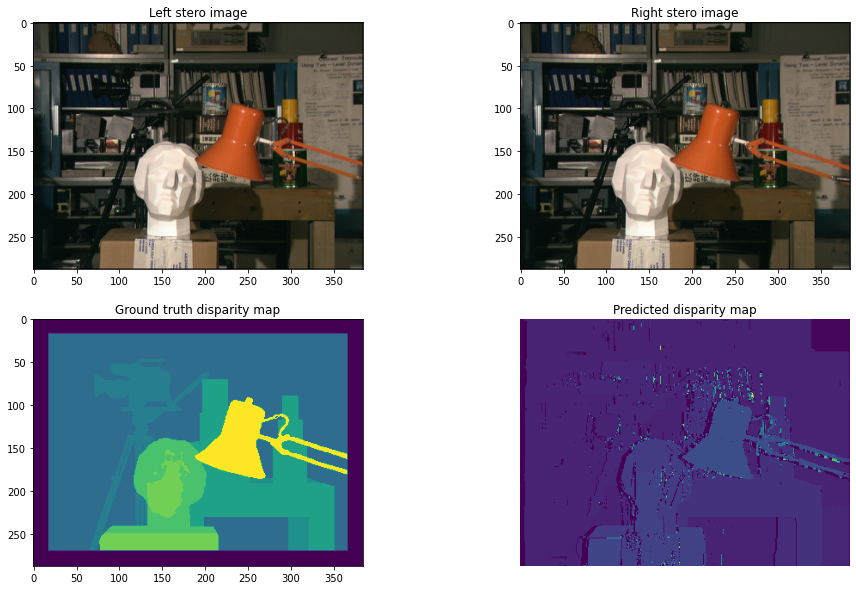

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
# plt.subplots_adjust(wspace=0, hspace=0)

axes[0][0].imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
axes[0][1].imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
axes[1][0].imshow(gt_disparity)
axes[1][1].imshow(disparity_graphcut)


axes[0][0].set_title('Left stero image')
axes[0][1].set_title('Right stero image')
axes[1][0].set_title('Ground truth disparity map')
axes[1][1].set_title('Predicted disparity map')

plt.axis('off')
fig.show()

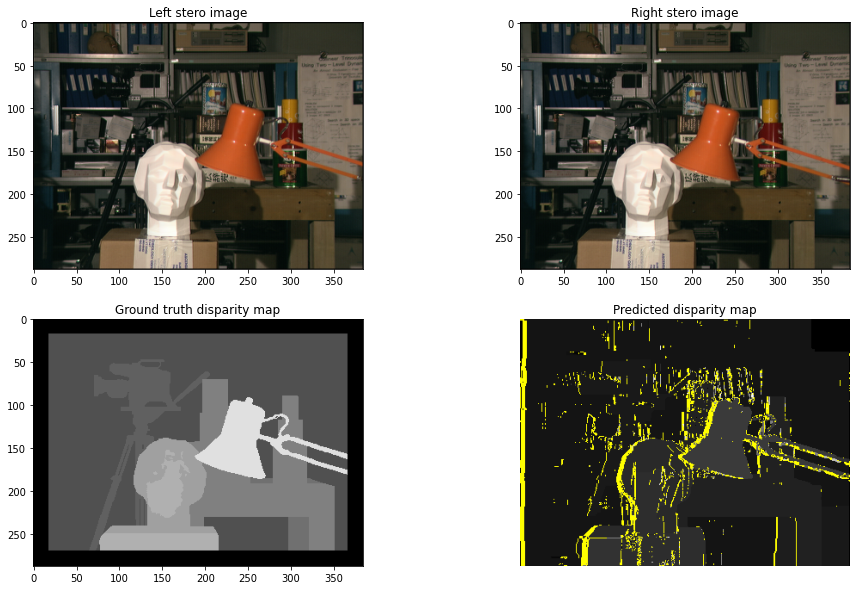

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
# plt.subplots_adjust(wspace=0, hspace=0)

axes[0][0].imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
axes[0][1].imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
axes[1][0].imshow(gt_disparity,cmap='gray', vmin=0, vmax=255)
axes[1][1].imshow(disparity_to_gray(disparity_graphcut),cmap='gray', vmin=0, vmax=255)



axes[0][0].set_title('Left stero image')
axes[0][1].set_title('Right stero image')
axes[1][0].set_title('Ground truth disparity map')
axes[1][1].set_title('Predicted disparity map')

plt.axis('off')
fig.show()

In [16]:
occlusion_percentage, total_error_percentage, gross_error_percentage = compute_metrics(gt_disparity,disparity_graphcut)
print(f"Total runtime of the program is: {end - begin} sec")
print(f"The percentage of occluded pixels in the disparity map is: {occlusion_percentage}%")
print(f"Total error: The percentage of incorrectly identified disparities is: {total_error_percentage}%")
print(f"Gross error: {gross_error_percentage}%")

Total runtime of the program is: 1207.9709558486938 sec
The percentage of occluded pixels in the disparity map is: 6.462492766203703%
Total error: The percentage of incorrectly identified disparities is: 97.97960268741843%
Gross error: 2.020397312581565%


## Experimet 2


```
occlusion_cost = 150
smoothness_cost = 30
number of iteration = 10

disparity range = 100
```



In [19]:
begin = time.time()
# search_depth, occlusion_cost, pfm_scale = 61, 80, 0.25            #REPORT_IMAGES[image_pair]
search_depth, occlusion_cost = 100, 150
disparity_graphcut = None
disparity_graphcut = disparity(left_image, right_image, search_depth=search_depth, max_iterations= 10, occlusion_cost=occlusion_cost,)
end = time.time()

if disparity_graphcut is not  None:
    cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/CV_A4/results/predicted_disparity2.png',disparity_to_gray(disparity_graphcut))

<ipython-input-7-e0006a1f4bf9>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diff_left = self.image_left[list(indices_p)] - self.image_left[list(indices_q)]
<ipython-input-7-e0006a1f4bf9>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = np.full(self.image_shape, self.LABEL_OCCLUDED, dtype=np.int)
<ipytho

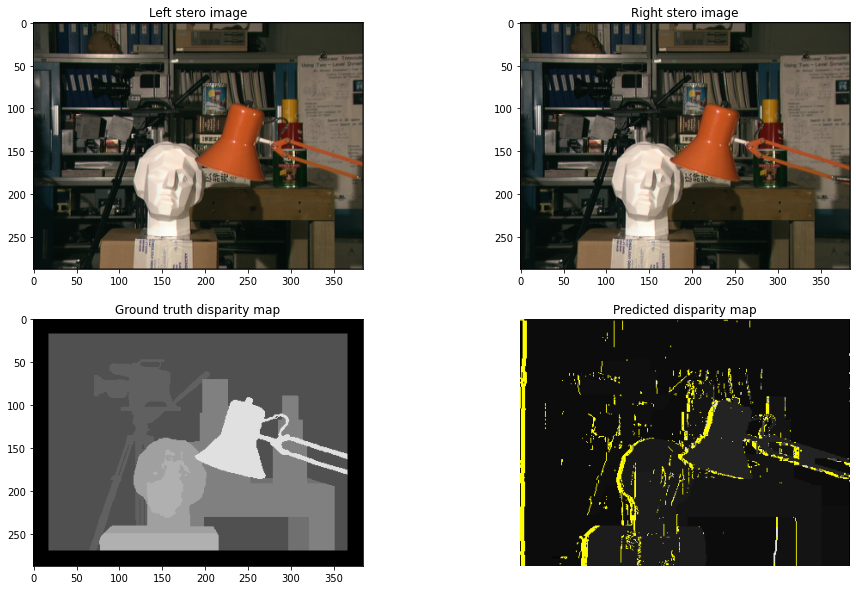

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
# plt.subplots_adjust(wspace=0, hspace=0)

axes[0][0].imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
axes[0][1].imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
axes[1][0].imshow(gt_disparity,cmap='gray', vmin=0, vmax=255)
axes[1][1].imshow(disparity_to_gray(disparity_graphcut),cmap='gray', vmin=0, vmax=255)
axes[0][0].set_title('Left stero image')
axes[0][1].set_title('Right stero image')
axes[1][0].set_title('Ground truth disparity map')
axes[1][1].set_title('Predicted disparity map')

plt.axis('off')
fig.show()

In [21]:
occlusion_percentage, total_error_percentage, gross_error_percentage = compute_metrics(gt_disparity,disparity_graphcut)
print(f"Total runtime of the program is: {end - begin}")
print(f"The percentage of occluded pixels in the disparity map is: {occlusion_percentage}")
print(f"Total error: The percentage of incorrectly identified disparities is: {total_error_percentage}")
print(f"Gross error: {gross_error_percentage}")

Total runtime of the program is: 4435.409597158432
The percentage of occluded pixels in the disparity map is: 4.890950520833334
Total error: The percentage of incorrectly identified disparities is: 84.50319918618028
Gross error: 15.496800813819725


## Experiment 3


```
occlusion_cost = 200
smoothness_cost = 40
number of iteration = 15
disparity range = 150
```



In [22]:
begin = time.time()
search_depth, occlusion_cost = 150, 200
disparity_graphcut = None
disparity_graphcut = disparity(left_image, right_image, search_depth=search_depth, max_iterations= 15, occlusion_cost=occlusion_cost,)
end = time.time()

if disparity_graphcut is not  None:
    cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/CV_A4/results/predicted_disparity3.png',disparity_to_gray(disparity_graphcut))

<ipython-input-7-e0006a1f4bf9>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diff_left = self.image_left[list(indices_p)] - self.image_left[list(indices_q)]
<ipython-input-7-e0006a1f4bf9>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = np.full(self.image_shape, self.LABEL_OCCLUDED, dtype=np.int)
<ipytho

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
# plt.subplots_adjust(wspace=0, hspace=0)

axes[0][0].imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
axes[0][1].imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
axes[1][0].imshow(gt_disparity,cmap='gray', vmin=0, vmax=255)
axes[1][1].imshow(disparity_to_gray(disparity_graphcut),cmap='gray', vmin=0, vmax=255)
axes[0][0].set_title('Left stero image')
axes[0][1].set_title('Right stero image')
axes[1][0].set_title('Ground truth disparity map')
axes[1][1].set_title('Predicted disparity map')

plt.axis('off')
fig.show()

In [24]:
occlusion_percentage, total_error_percentage, gross_error_percentage = compute_metrics(gt_disparity,disparity_graphcut)
print(f"Total runtime of the program is: {end - begin}")
print(f"The percentage of occluded pixels in the disparity map is: {occlusion_percentage}")
print(f"Total error: The percentage of incorrectly identified disparities is: {total_error_percentage}")
print(f"Gross error: {gross_error_percentage}")

Total runtime of the program is: 9689.8729159832
The percentage of occluded pixels in the disparity map is: 4.378255208333334
Total error: The percentage of incorrectly identified disparities is: 82.41985815602837
Gross error: 17.58014184397163


## Experiment 4


```
occlusion_cost = 60
smoothness_cost = 12
number of iteration = 5

disparity range = 10
```



In [33]:
begin = time.time()
search_depth, occlusion_cost = 10, 60
disparity_graphcut = None
# (self,image_left,image_right,always_randomize=False,search_depth=30,max_levels=-1,max_iterations = 5,occlusion_cost=-1,
                #  smoothness_cost_high=-1,smoothness_cost_low=-1,smoothness_threshold=8,)
disparity_graphcut = disparity(left_image, right_image, search_depth=search_depth, max_iterations= 5, occlusion_cost=occlusion_cost,)
end = time.time()

if disparity_graphcut is not  None:
    cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/CV_A4/results/predicted_disparity4.png',disparity_to_gray(disparity_graphcut))

<ipython-input-7-e0006a1f4bf9>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diff_left = self.image_left[list(indices_p)] - self.image_left[list(indices_q)]
<ipython-input-7-e0006a1f4bf9>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = np.full(self.image_shape, self.LABEL_OCCLUDED, dtype=np.int)
<ipytho

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
# plt.subplots_adjust(wspace=0, hspace=0)

axes[0][0].imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
axes[0][1].imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
axes[1][0].imshow(gt_disparity,cmap='gray', vmin=0, vmax=255)
axes[1][1].imshow(disparity_to_gray(disparity_graphcut),cmap='gray', vmin=0, vmax=255)
axes[0][0].set_title('Left stero image')
axes[0][1].set_title('Right stero image')
axes[1][0].set_title('Ground truth disparity map')
axes[1][1].set_title('Predicted disparity map')

plt.axis('off')
fig.show()

In [35]:
occlusion_percentage, total_error_percentage, gross_error_percentage = compute_metrics(gt_disparity,disparity_graphcut)
print(f"Total runtime of the program is: {end - begin}")
print(f"The percentage of occluded pixels in the disparity map is: {occlusion_percentage}")
print(f"Total error: The percentage of incorrectly identified disparities is: {total_error_percentage}")
print(f"Gross error: {gross_error_percentage}")

Total runtime of the program is: 234.1885108947754
The percentage of occluded pixels in the disparity map is: 10.9619140625
Total error: The percentage of incorrectly identified disparities is: 96.41714651311581
Gross error: 3.5828534868841975


In [36]:
# This will return a new array containing the Birchfield-Tomasi dissimilarity measure for each pixel in the input maps.
bt_measure = birchfield_tomasi_measure(disparity_graphcut, gt_disparity)
print(bt_measure)

[[0.89583414 0.89583414 0.89583414 ... 0.64403642 0.64403642 0.64403642]
 [0.89583414 0.89583414 0.89583414 ... 0.64403642 0.64403642 0.64403642]
 [0.89583414 0.89583414 0.89583414 ... 0.64403642 0.64403642 1.        ]
 ...
 [1.         0.89583414 0.89583414 ... 0.51685133 0.51685133 1.        ]
 [1.         0.89583414 0.89583414 ... 0.51685133 0.51685133 1.        ]
 [1.         0.89583414 0.89583414 ... 0.51685133 0.51685133 1.        ]]


## Experiment 5


```
occlusion_cost = 40
smoothness_cost = 5
number of iteration = 5

disparity range = 15
```


In [30]:
begin = time.time()
search_depth, occlusion_cost = 15, 40
disparity_graphcut = None
# (self,image_left,image_right,always_randomize=False,search_depth=30,max_levels=-1,max_iterations = 5,occlusion_cost=-1,
                #  smoothness_cost_high=-1,smoothness_cost_low=-1,smoothness_threshold=8,)
disparity_graphcut = disparity(left_image, right_image, search_depth=search_depth, max_iterations= 5, occlusion_cost=occlusion_cost,)
end = time.time()

if disparity_graphcut is not  None:
    cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/CV_A4/results/predicted_disparity5.png',disparity_to_gray(disparity_graphcut))

<ipython-input-7-e0006a1f4bf9>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diff_left = self.image_left[list(indices_p)] - self.image_left[list(indices_q)]
<ipython-input-7-e0006a1f4bf9>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = np.full(self.image_shape, self.LABEL_OCCLUDED, dtype=np.int)
<ipytho

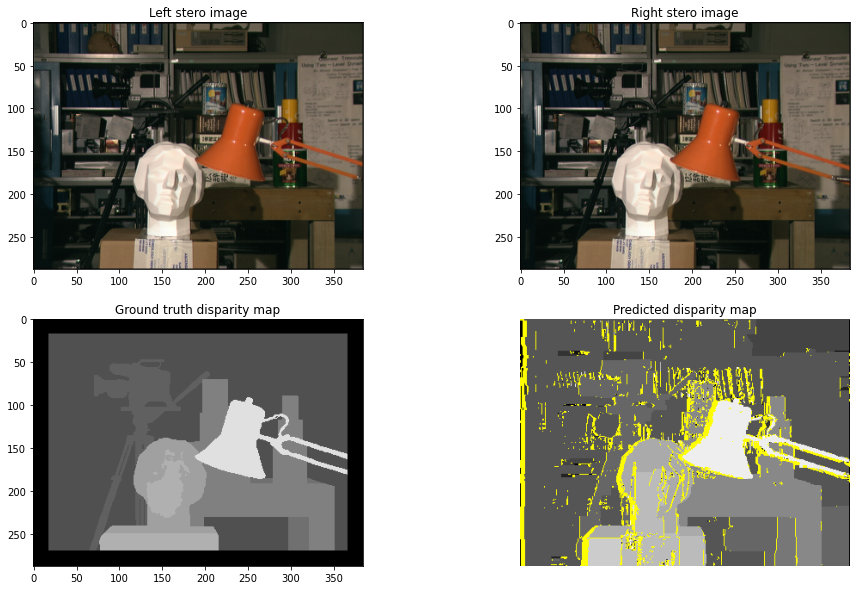

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
# plt.subplots_adjust(wspace=0, hspace=0)

axes[0][0].imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
axes[0][1].imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
axes[1][0].imshow(gt_disparity,cmap='gray', vmin=0, vmax=255)
axes[1][1].imshow(disparity_to_gray(disparity_graphcut),cmap='gray', vmin=0, vmax=255)
axes[0][0].set_title('Left stero image')
axes[0][1].set_title('Right stero image')
axes[1][0].set_title('Ground truth disparity map')
axes[1][1].set_title('Predicted disparity map')

plt.axis('off')
fig.show()

In [32]:
occlusion_percentage, total_error_percentage, gross_error_percentage = compute_metrics(gt_disparity,disparity_graphcut)
print(f"Total runtime of the program is: {end - begin}")
print(f"The percentage of occluded pixels in the disparity map is: {occlusion_percentage}")
print(f"Total error: The percentage of incorrectly identified disparities is: {total_error_percentage}")
print(f"Gross error: {gross_error_percentage}")

Total runtime of the program is: 353.6351752281189
The percentage of occluded pixels in the disparity map is: 9.566695601851851
Total error: The percentage of incorrectly identified disparities is: 26.003879534455866
Gross error: 73.99612046554414


In [29]:
# This will return a new array containing the Birchfield-Tomasi dissimilarity measure for each pixel in the input maps.
bt_measure = birchfield_tomasi_measure(disparity_graphcut, gt_disparity)
print(bt_measure)

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 0.8025188  0.8025188  1.        ]
 [1.         1.         1.         ... 0.8025188  0.8025188  1.        ]
 [1.         1.         1.         ... 0.33287108 0.33287108 1.        ]]


## Experiment 6


```
occlusion_cost = 50
smoothness_cost = 10
number of iteration = 5

disparity range = 10
```


In [45]:
begin = time.time()
search_depth, occlusion_cost = 10, 50
disparity_graphcut = None
# (self,image_left,image_right,always_randomize=False,search_depth=30,max_levels=-1,max_iterations = 5,occlusion_cost=-1,
                #  smoothness_cost_high=-1,smoothness_cost_low=-1,smoothness_threshold=8,)
disparity_graphcut = disparity(left_image, right_image, search_depth=search_depth, max_iterations= 5, occlusion_cost=occlusion_cost,)
end = time.time()

if disparity_graphcut is not  None:
    cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/CV_A4/results/predicted_disparity6.png',disparity_to_gray(disparity_graphcut))

<ipython-input-7-e0006a1f4bf9>:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diff_left = self.image_left[list(indices_p)] - self.image_left[list(indices_q)]
<ipython-input-7-e0006a1f4bf9>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = np.full(self.image_shape, self.LABEL_OCCLUDED, dtype=np.int)
<ipytho

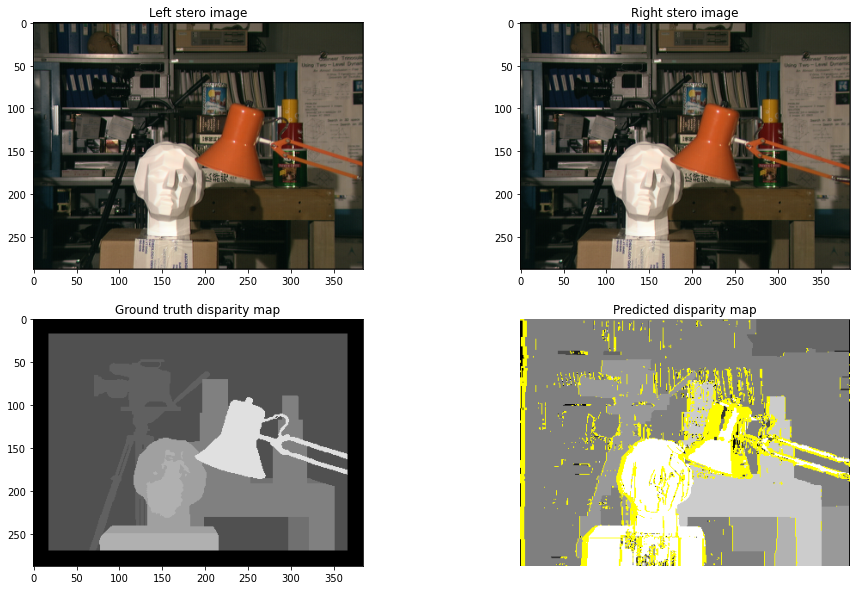

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
# plt.subplots_adjust(wspace=0, hspace=0)

axes[0][0].imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
axes[0][1].imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
axes[1][0].imshow(gt_disparity,cmap='gray', vmin=0, vmax=255)
axes[1][1].imshow(disparity_to_gray(disparity_graphcut),cmap='gray', vmin=0, vmax=255)
axes[0][0].set_title('Left stero image')
axes[0][1].set_title('Right stero image')
axes[1][0].set_title('Ground truth disparity map')
axes[1][1].set_title('Predicted disparity map')

plt.axis('off')
fig.show()

In [47]:
occlusion_percentage, total_error_percentage, gross_error_percentage = compute_metrics(gt_disparity,disparity_graphcut)
print(f"Total runtime of the program is: {end - begin}")
print(f"The percentage of occluded pixels in the disparity map is: {occlusion_percentage}")
print(f"Total error: The percentage of incorrectly identified disparities is: {total_error_percentage}")
print(f"Gross error: {gross_error_percentage}")

Total runtime of the program is: 268.8674998283386
The percentage of occluded pixels in the disparity map is: 11.71875
Total error: The percentage of incorrectly identified disparities is: 96.62098492297608
Gross error: 3.3790150770239267


In [48]:
# This will return a new array containing the Birchfield-Tomasi dissimilarity measure for each pixel in the input maps.
bt_measure = birchfield_tomasi_measure(disparity_graphcut, gt_disparity)
print(bt_measure)

[[0.89583414 0.89583414 0.89583414 ... 0.64403642 0.64403642 0.64403642]
 [0.89583414 0.89583414 0.89583414 ... 0.64403642 0.64403642 0.64403642]
 [0.89583414 0.89583414 0.89583414 ... 0.64403642 0.64403642 1.        ]
 ...
 [1.         0.89583414 0.89583414 ... 0.51685133 0.51685133 1.        ]
 [1.         0.89583414 0.89583414 ... 0.51685133 0.51685133 1.        ]
 [1.         0.89583414 0.89583414 ... 0.51685133 0.51685133 1.        ]]


## Report


```
Experiments
For each experiment, describe the results you observe briefly.
1. Include a study of how changes in the various parameters (in the below list) affect the results.
a. Varying λ.
b. Varying the maximum number of iterations.
c. Varying the disparity range.
```

* As we can see from above experiment if we increase the occlusion cost then we get less number of occluded pixels.  

* When we decrease the λ, results disparity map looks smooth



# GrabCut
GrabCut algorithm was designed by Carsten Rother, Vladimir Kolmogorov & Andrew Blake from
Microsoft Research Cambridge, UK. In their paper, "GrabCut: interactive foreground extraction using
iterated graph cuts,” they have developed an algorithm for single object foreground extraction with
minimal user interaction.
You can use OpenCV’s implementation of Grabcut for this part of the assignment.


**Experiments**  

In this task, you have to do the following experiments (on 3 images of your choice from the dataset) with
GrabCut and evaluate the results using the evaluation metrics explained earlier
1. The number of iterations of GMM updating and energy minimization.
2. Effect of a tight initial bounding box or a loose bounding box.
3. Different color spaces or ways of representing pixels.
For each of the experiments, you need to give a brief description explaining the results you observe.


In [49]:
import numpy as np

import cv2 as cv

from matplotlib import pyplot as plt

from google.colab.patches import cv2_imshow

In [50]:
moon = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-2-grabcut/images/fullmoon.jpg'
moon_gt = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-2-grabcut/ground_truth/fullmoon.bmp'
ilama = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-2-grabcut/images/llama.jpg'
ilama_gt = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-2-grabcut/ground_truth/llama.bmp'
book = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-2-grabcut/images/book.jpg'
book_gt = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-2-grabcut/ground_truth/book.bmp'

banana1 = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-2-grabcut/images/banana1.jpg'
banana1_gt = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-2-grabcut/ground_truth/banana1.bmp'
cross = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-2-grabcut/images/cross.jpg'
cross_gt = '/content/drive/MyDrive/Colab Notebooks/CV_A4/data/section-2-grabcut/ground_truth/cross.bmp'

In [51]:
moon_loose_top_left = (125,91)
moon_loose_bottom_right = (309,251)
moon_tight_top_left = (152,117)
moon_tight_bottom_right = (267,228)

ilama_loose_top_left = (74,72)
ilama_loose_bottom_right = (409,370)
ilama_tight_top_left = (122,118)
ilama_tight_bottom_right = (358,370)

book_loose_top_left = (37,30)
book_loose_bottom_right = (612,456)
book_tight_top_left = (76,40)
book_tight_bottom_right = (599,441)

banana1_loose_top_left = (11,13)
banana1_loose_bottom_right = (622,448)
banana1_tight_top_left = (33,36)
banana1_tight_bottom_right = (605,419)

cross_loose_top_left = (71,16)
cross_loose_bottom_right = (358,311)
cross_tight_top_left = (18,16)
cross_tight_bottom_right = (430,535)

In [ ]:
def show_images(img1,img2,img3):
  # Resize the images to the same width
  height, width = img1.shape[:2]
  new_width = 300
  new_height = int(height * new_width / width)
  img1 = cv.resize(img1, (new_width, new_height))
  img2 = cv.resize(img2, (new_width, new_height))
  img3 = cv.resize(img3, (new_width, new_height))

  # Create a blank image with three times the width
  blank_image = np.zeros((new_height, new_width * 3, 3), np.uint8)

  # Paste the three images into the blank image
  blank_image[0:new_height, 0:new_width] = img1
  blank_image[0:new_height, new_width:new_width * 2] = img2
  blank_image[0:new_height, new_width * 2:new_width * 3] = img3

  # Show the result
  cv2_imshow(blank_image)


Original Images: 



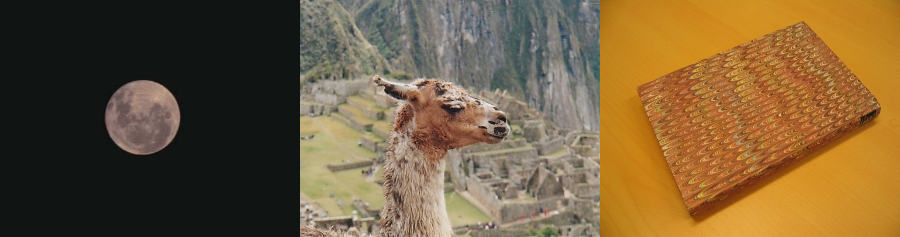

In [ ]:
moon_img = cv.imread(moon)
ilama_img = cv.imread(ilama)
book_img = cv.imread(book)
print('Original Images: \n')
show_images(moon_img,ilama_img,book_img)


## Grab-Cut Implementation

In [61]:
def grabcut_image(image_path, x, y, width, height, num_iter, mask_file_exists = False, mask_path = '', hsv_colorspace = False):
  img = cv.imread(image_path)

  if (hsv_colorspace):
    img = cv.cvtColor(img, cv.COLOR_BGR2HSV)

  mask = np.zeros(img.shape[:2], np.uint8)

  bgdModel = np.zeros((1,65), np.float64)
  fgdModel = np.zeros((1,65), np.float64)

  rect = (x, y, width, height)

  cv.grabCut(img, mask, rect, bgdModel, fgdModel, num_iter, cv.GC_INIT_WITH_RECT)
  
  mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

  img = img*mask2[:,:,np.newaxis]

  if (mask_file_exists):
    # newmask is the mask image I manually labelled
    newmask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
    # wherever it is marked white (sure foreground), change mask=1
    # wherever it is marked black (sure background), change mask=0

    mask[newmask == 0] = 0
    mask[newmask == 255] = 1

    mask, bgdModel, fgdModel = cv.grabCut(img,mask, None, bgdModel, fgdModel, num_iter, cv.GC_INIT_WITH_MASK)
    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask[:,:,np.newaxis]
    # plt.imshow(img),plt.colorbar(),plt.show()

  # plt.imshow(img), plt.colorbar(), plt.show()

  return img

## Loose Bounding Box

In [ ]:
# find the top-left and bottom-right corner points of the rectangle which contains the object in the image 
def loose_bounding_box(img,top_left,bottom_right):
  # Blue color in BGR
  color = (255, 0, 0)
  # Line thickness of 2 px
  thickness = 2
  image_rect = cv.rectangle(img.copy(), top_left, bottom_right, color, thickness)
  # cv2_imshow(image_rect)
  return image_rect

In [ ]:
moon_x = moon_loose_top_left[0]
moon_y = moon_loose_top_left[1]
moon_width = moon_loose_bottom_right[0] - moon_loose_top_left[0]
moon_height = moon_loose_bottom_right[1] - moon_loose_top_left[1]

book_x = book_loose_top_left[0]
book_y = book_loose_top_left[1]
book_width = book_loose_bottom_right[0] - book_loose_top_left[0]
book_height = book_loose_bottom_right[1] - book_loose_top_left[1]

ilama_x = ilama_loose_top_left[0]
ilama_y = ilama_loose_top_left[1]
ilama_width = ilama_loose_bottom_right[0] - ilama_loose_top_left[0]
ilama_height = ilama_loose_bottom_right[1] - ilama_loose_top_left[1]

In [ ]:
moon_image_react = loose_bounding_box(moon_img,moon_loose_top_left,moon_loose_bottom_right)
book_image_react = loose_bounding_box(book_img,book_loose_top_left,book_loose_bottom_right)
ilama_image_react = loose_bounding_box(ilama_img,ilama_loose_top_left,ilama_loose_bottom_right)


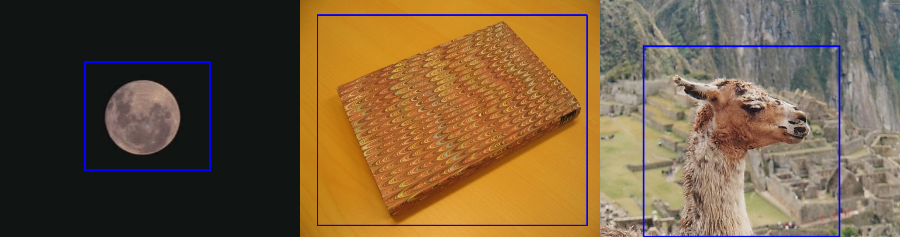

In [ ]:
show_images(moon_image_react,book_image_react,ilama_image_react)

In [ ]:
# num of iterations is 5
moon_res = grabcut_image(moon, moon_x, moon_y, moon_width, moon_height, 5)
book_res = grabcut_image(book, book_x, book_y, book_width, book_height, 5)
ilama_res = grabcut_image(ilama, ilama_x, ilama_y, ilama_width, ilama_height, 5)

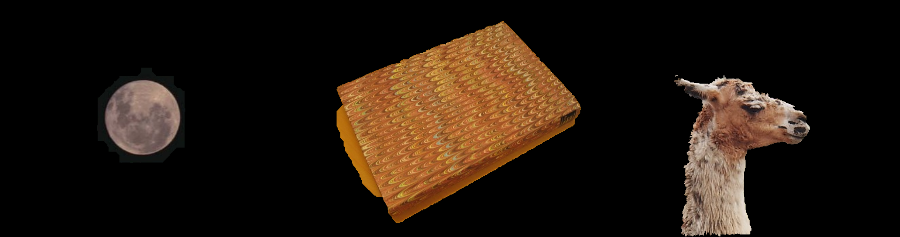

In [ ]:
show_images(moon_res,book_res,ilama_res)

In [ ]:
# num of iterations is 10
moon_res = grabcut_image(moon, moon_x, moon_y, moon_width, moon_height, 10)
book_res = grabcut_image(book, book_x, book_y, book_width, book_height, 10)
ilama_res = grabcut_image(ilama, ilama_x, ilama_y, ilama_width, ilama_height, 10)

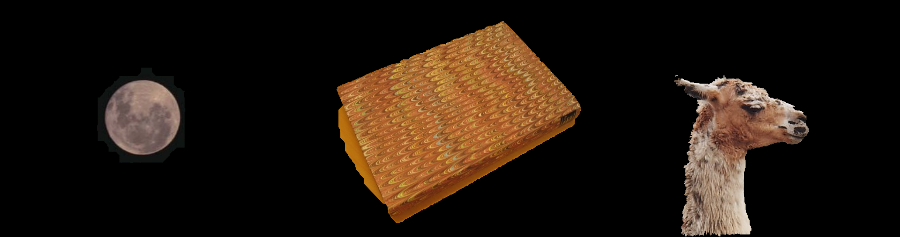

In [ ]:
show_images(moon_res,book_res,ilama_res)

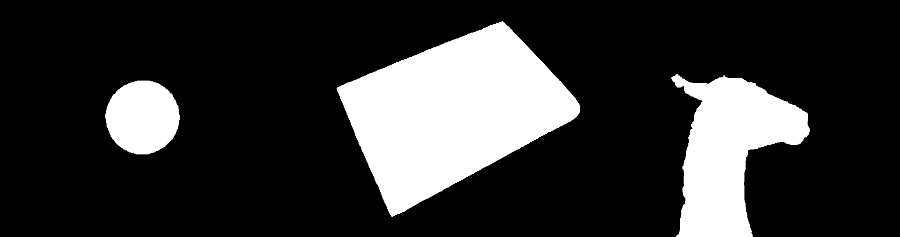

In [ ]:
moon_gt_img = cv.imread(moon_gt)
book_gt_img = cv.imread(book_gt)
ilama_gt_img = cv.imread(ilama_gt)

show_images(moon_gt_img,book_gt_img,ilama_gt_img)

## Tight Bounding Box

In [57]:
def tight_bounding_box(img,top_left,bottom_right):
  # Blue color in BGR
  color = (255, 0, 0)
  # Line thickness of 2 px
  thickness = 2
  image_rect = cv.rectangle(img.copy(), top_left, bottom_right, color, thickness)
  return image_rect

In [ ]:
moon_x = moon_tight_top_left[0]
moon_y = moon_tight_top_left[1]
moon_width = moon_tight_bottom_right[0] - moon_tight_top_left[0]
moon_height = moon_tight_bottom_right[1] - moon_tight_top_left[1]

book_x = book_tight_top_left[0]
book_y = book_tight_top_left[1]
book_width = book_tight_bottom_right[0] - book_tight_top_left[0]
book_height = book_tight_bottom_right[1] - book_tight_top_left[1]

ilama_x = ilama_tight_top_left[0]
ilama_y = ilama_tight_top_left[1]
ilama_width = ilama_tight_bottom_right[0] - ilama_tight_top_left[0]
ilama_height = ilama_tight_bottom_right[1] - ilama_tight_top_left[1]

In [ ]:
moon_image_react = tight_bounding_box(moon_img,moon_tight_top_left,moon_tight_bottom_right)
book_image_react = tight_bounding_box(book_img,book_tight_top_left,book_tight_bottom_right)
ilama_image_react = tight_bounding_box(ilama_img,ilama_tight_top_left,ilama_tight_bottom_right)


In [ ]:
show_images(moon_image_react,book_image_react,ilama_image_react)

In [ ]:
# num of iterations is 5
moon_res = grabcut_image(moon, moon_x, moon_y, moon_width, moon_height, 5)
book_res = grabcut_image(book, book_x, book_y, book_width, book_height, 5)
ilama_res = grabcut_image(ilama, ilama_x, ilama_y, ilama_width, ilama_height, 5)

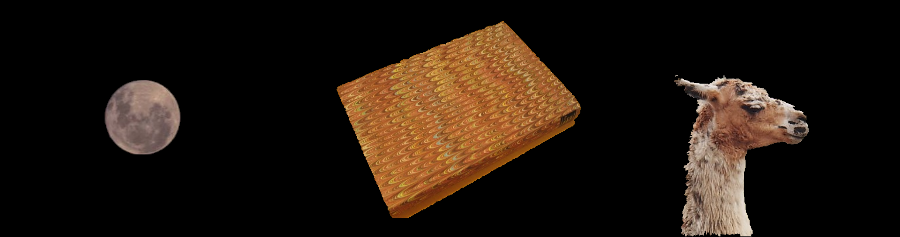

In [ ]:
show_images(moon_res,book_res,ilama_res)

In [ ]:
# num of iterations is 10
moon_res = grabcut_image(moon, moon_x, moon_y, moon_width, moon_height, 10)
book_res = grabcut_image(book, book_x, book_y, book_width, book_height, 10)
ilama_res = grabcut_image(ilama, ilama_x, ilama_y, ilama_width, ilama_height, 10)

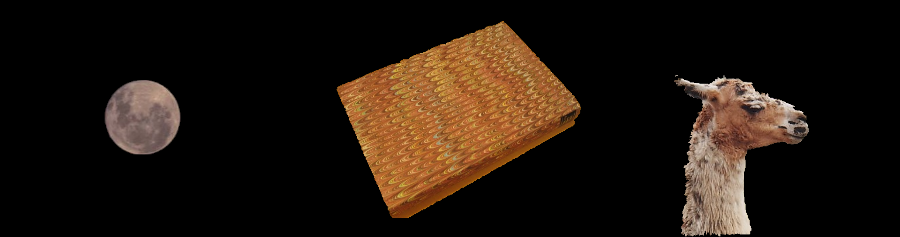

In [ ]:
show_images(moon_res,book_res,ilama_res)

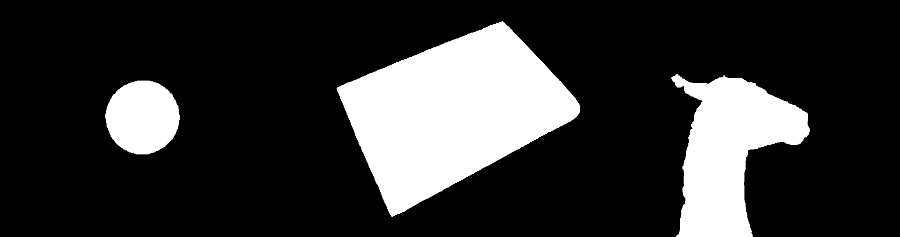

In [ ]:
show_images(moon_gt_img,book_gt_img,ilama_gt_img)

## Open image in HSV Color Space

In [ ]:
hsv_moon_img = cv.cvtColor(moon_img, cv.COLOR_BGR2HSV)
hsv_book_img = cv.cvtColor(book_img, cv.COLOR_BGR2HSV)
hsv_ilama_img = cv.cvtColor(ilama_img, cv.COLOR_BGR2HSV)

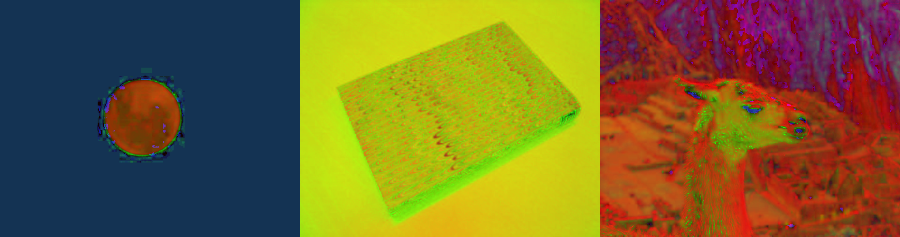

In [ ]:
show_images(hsv_moon_img,hsv_book_img,hsv_ilama_img)

In [ ]:
moon_x = moon_tight_top_left[0]
moon_y = moon_tight_top_left[1]
moon_width = moon_tight_bottom_right[0] - moon_tight_top_left[0]
moon_height = moon_tight_bottom_right[1] - moon_tight_top_left[1]

book_x = book_tight_top_left[0]
book_y = book_tight_top_left[1]
book_width = book_tight_bottom_right[0] - book_tight_top_left[0]
book_height = book_tight_bottom_right[1] - book_tight_top_left[1]

ilama_x = ilama_tight_top_left[0]
ilama_y = ilama_tight_top_left[1]
ilama_width = ilama_tight_bottom_right[0] - ilama_tight_top_left[0]
ilama_height = ilama_tight_bottom_right[1] - ilama_tight_top_left[1]

In [ ]:
moon_image_react = tight_bounding_box(hsv_moon_img,moon_tight_top_left,moon_tight_bottom_right)
book_image_react = tight_bounding_box(hsv_book_img,book_tight_top_left,book_tight_bottom_right)
ilama_image_react = tight_bounding_box(hsv_ilama_img,ilama_tight_top_left,ilama_tight_bottom_right)


In [ ]:
show_images(moon_image_react,book_image_react,ilama_image_react)

In [ ]:
# num of iterations is 10
moon_res = grabcut_image(moon, moon_x, moon_y, moon_width, moon_height, 10, hsv_colorspace=True)
book_res = grabcut_image(book, book_x, book_y, book_width, book_height, 10, hsv_colorspace=True)
ilama_res = grabcut_image(ilama, ilama_x, ilama_y, ilama_width, ilama_height, 10, hsv_colorspace=True)

In [ ]:
show_images(moon_res,book_res,ilama_res)

## Results
The images above demonstrate that the segmentation results improve with an increase in the number of iterations up to a certain point. However, further increasing the number of iterations does not lead to any significant improvement in the segmentation results.

The use of tighter bounding boxes yields better segmentation results as it reduces the chances of other background objects being mistakenly classified as the foreground object. Conversely, looser bounding boxes can result in multiple background objects with similar characteristics to the foreground object being misclassified.

The segmentation results for images in different color spaces, such as the HSV color space, were also found to be satisfactory. The choice of color space depends on the specific segmentation task and the characteristics of the dataset.

## Additional Experiment

### Evaluation Metrics

In [ ]:
def calculate_metrics(res,gt):
  new_res = res.flatten()
  new_gt = gt.flatten()

  # convert resultant image to binary
  for i in range(len(new_res)):
    if (new_res[i] > 0):
      new_res[i] = 255

  c = 0
  for i in range(len(new_res)):
    # pixel is 
    if (new_res[i] == new_gt[i]):
      c += 1

  print("Accuracy:", c/len(new_gt))

  intersection = np.logical_and(new_res, new_gt)
  union = np.logical_or(new_res, new_gt)
  iou_score = np.sum(intersection) / np.sum(union)
  print("IoU Score: ", iou_score)

  intersection = np.logical_and(new_res, new_gt)
  num = 2*np.sum(intersection)
  fc = np.sum(new_res)/255 
  sc = np.sum(new_gt)/255
  den = fc+sc
  dsc = num/den 
  print("Dice similarity coefficient: ", dsc)

In [ ]:
def show_four_images(image1,image2,image3,image4):
  # Resize the images to the same size (optional)
  image1 = cv.resize(image1, (400, 300))
  image2 = cv.resize(image2, (400, 300))
  image3 = cv.resize(image3, (400, 300))
  image4 = cv.resize(image4, (400, 300))
  # Concatenate the images horizontally
  row1 = cv.hconcat([image1, image2])
  row2 = cv.hconcat([image3, image4])
  final_image = cv.vconcat([row1, row2])
  # Show the final image
  cv2_imshow( final_image)


In [ ]:
moon_img = cv.imread(moon)
ilama_img = cv.imread(ilama)
banana1_img = cv.imread(banana1)
cross_img = cv.imread(cross)

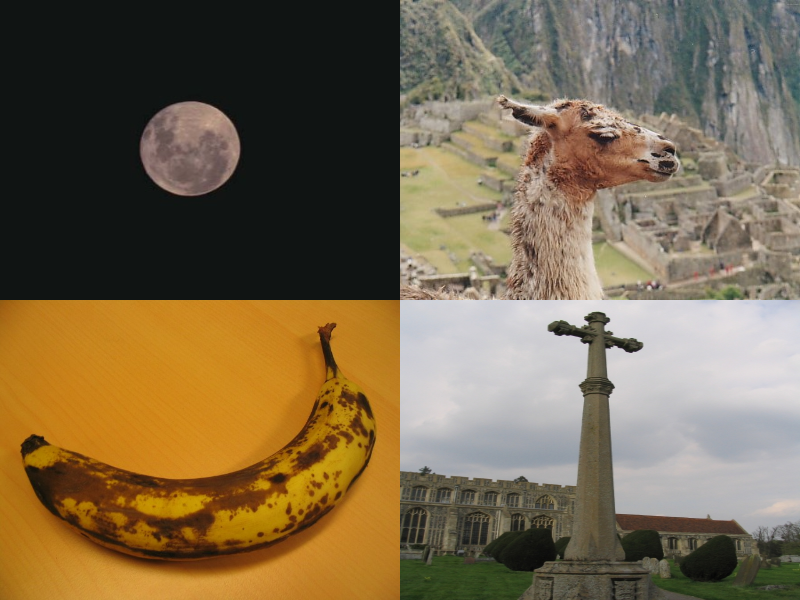

In [ ]:
show_four_images(moon_img,ilama_img,banana1_img,cross_img)

In [ ]:
moon_x = moon_tight_top_left[0]
moon_y = moon_tight_top_left[1]
moon_width = moon_tight_bottom_right[0] - moon_tight_top_left[0]
moon_height = moon_tight_bottom_right[1] - moon_tight_top_left[1]

ilama_x = ilama_tight_top_left[0]
ilama_y = ilama_tight_top_left[1]
ilama_width = ilama_tight_bottom_right[0] - ilama_tight_top_left[0]
ilama_height = ilama_tight_bottom_right[1] - ilama_tight_top_left[1]

banana1_x = banana1_tight_top_left[0]
banana1_y = banana1_tight_top_left[1]
banana1_width = banana1_tight_bottom_right[0] - banana1_tight_top_left[0]
banana1_height = banana1_tight_bottom_right[1] - banana1_tight_top_left[1]

cross_x = cross_tight_top_left[0]
cross_y = cross_tight_top_left[1]
cross_width = cross_tight_bottom_right[0] - cross_tight_top_left[0]
cross_height = cross_tight_bottom_right[1] - cross_tight_top_left[1]

In [ ]:
moon_image_react = tight_bounding_box(moon_img,moon_tight_top_left,moon_tight_bottom_right)
ilama_image_react = tight_bounding_box(ilama_img,ilama_tight_top_left,ilama_tight_bottom_right)

banana1_image_react = tight_bounding_box(banana1_img,banana1_tight_top_left,banana1_tight_bottom_right)
cross_image_react = tight_bounding_box(cross_img,cross_tight_top_left,cross_tight_bottom_right)

In [ ]:
show_four_images(moon_image_react,ilama_image_react,banana1_image_react,cross_image_react)

In [ ]:
# num of iterations is 10
moon_res = grabcut_image(moon, moon_x, moon_y, moon_width, moon_height, 10)
ilama_res = grabcut_image(ilama, ilama_x, ilama_y, ilama_width, ilama_height, 10)
banana1_res = grabcut_image(banana1, banana1_x, banana1_y, banana1_width, banana1_height, 10)
cross_res = grabcut_image(cross, cross_x, cross_y, cross_width, cross_height, 10)

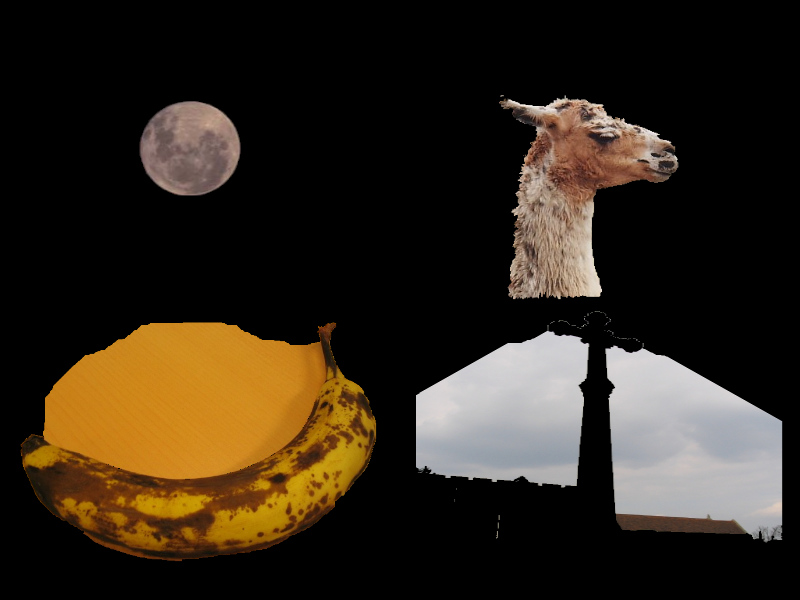

In [ ]:
show_four_images(moon_res,ilama_res,banana1_res,cross_res)

In [ ]:
moon_gt_img = cv.imread(moon_gt)
ilama_gt_img = cv.imread(ilama_gt)
banana1_gt_img = cv.imread(banana1_gt)
cross_gt_img = cv.imread(cross_gt)

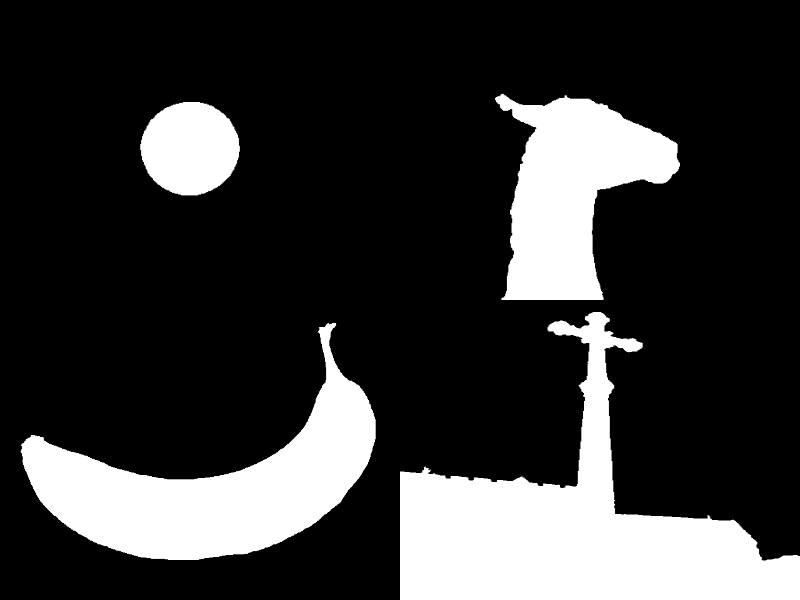

In [ ]:
show_four_images(moon_gt_img,ilama_gt_img,banana1_gt_img,cross_gt_img)

In [ ]:
print("MATREICS OF FULL MOON IMAGE:\n ")
calculate_metrics(moon_res,moon_gt_img)

MATREICS OF FULL MOON IMAGE:
 
Accuracy: 0.9968972204266322
IoU Score:  0.9510603588907015
Dice similarity coefficient:  0.9749163879598662


In [ ]:
print("MATREICS OF ilama IMAGE:\n ")
calculate_metrics(ilama_res,ilama_gt_img)

MATREICS OF ilama IMAGE:
 
Accuracy: 0.9874616660449166
IoU Score:  0.9287831761569376
Dice similarity coefficient:  0.9630768119903657


In [ ]:
print("MATREICS OF banana1 IMAGE:\n ")
calculate_metrics(banana1_res,banana1_gt_img)

MATREICS OF banana1 IMAGE:
 
Accuracy: 0.7062521701388889
IoU Score:  0.45378792158635106
Dice similarity coefficient:  0.6242835214797832


In [ ]:
print("MATREICS OF cross IMAGE:\n ")
calculate_metrics(cross_res,cross_gt_img)

MATREICS OF cross IMAGE:
 
Accuracy: 0.26464814814814813
IoU Score:  0.020609402978448425
Dice similarity coefficient:  0.04038646502433531


## Masking For Bad results

In [134]:
def show_2images(img1,img2):
  img1 = cv.resize(img1, (400, 300))
  img2 = cv.resize(img2, (400, 300))
  combined_img = cv.hconcat([img1, img2])
  cv2_imshow(combined_img)


In [135]:
banana1_mask_file = "/content/drive/MyDrive/Colab Notebooks/CV_A4/results/banana1.jpg" 
cross_mask_file = "/content/drive/MyDrive/Colab Notebooks/CV_A4/results/cross.jpg" 
banana1_mask = cv.imread(banana1_mask_file)
cross_mask = cv.imread(cross_mask_file)

In [140]:
cv2_imshow(cross_mask)

AttributeError: ignored

In [136]:
show_2images(banana1_mask,cross_mask)

error: ignored

In [137]:
banana1_x = banana1_tight_top_left[0]
banana1_y = banana1_tight_top_left[1]
banana1_width = banana1_tight_bottom_right[0] - banana1_tight_top_left[0]
banana1_height = banana1_tight_bottom_right[1] - banana1_tight_top_left[1]

cross_x = cross_tight_top_left[0]
cross_y = cross_tight_top_left[1]
cross_width = cross_tight_bottom_right[0] - cross_tight_top_left[0]
cross_height = cross_tight_bottom_right[1] - cross_tight_top_left[1]

In [138]:
banana1_mask_image_react = tight_bounding_box(banana1_mask,banana1_tight_top_left,banana1_tight_bottom_right)
cross_mask_image_react = tight_bounding_box(cross_mask,cross_tight_top_left,cross_tight_bottom_right)

AttributeError: ignored

In [ ]:
show_2images(banana1_mask_image_react,cross_mask_image_react)

In [133]:
banana1_mask_res = grabcut_image(banana1_mask_file, banana1_x, banana1_y, banana1_width, banana1_height, 5, True, banana1_mask_file)
cross_mask_res = grabcut_image(cross_mask_file, cross_x, cross_y, cross_width, cross_height, 5, True, cross_mask_file)

AttributeError: ignored

In [ ]:
show_2images(banana1_mask_res,cross_mask_res)

In [ ]:
print("MATREICS OF banana1 mask IMAGE:\n ")
calculate_metrics(banana1_mask_res,banana1_gt_img)

In [ ]:
print("MATREICS OF cross mask IMAGE:\n ")
calculate_metrics(cross_mask_res,cross_gt_img)

## Report 
As you can see from the above four images result that full moon and ilama image are giving good result, but others two banana1 and cross image did not give our expected ground truth result